In [1]:
!curl -O https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 1390k    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 1390k  100 1390k    0     0   967k      0  0:00:01  0:00:01 --:--:--  969k


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('./housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Preparing the dataset

In [4]:
# Keeping the records only where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [5]:
#Filling the missing values with zero
df = df.fillna(0)

In [6]:
# Applying the log transform to median_house_value
df['median_house_value'] = np.log1p(df['median_house_value'])

In [7]:
# train/validation/test split with 60%/20%/20% distribution.
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size =0.2, random_state = 1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state= 1)

In [8]:
y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values

In [9]:
del df_train['median_house_value']
del df_val['median_house_value']

In [10]:
# Using the DictVectorizer(sparse=True) to turn the dataframes into matrices.
from sklearn.feature_extraction import DictVectorizer

dict_train = df_train.to_dict(orient= 'records')
dict_val = df_val.to_dict(orient = 'records')

dv = DictVectorizer(sparse = True)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

### Question 1
Train a model with max_depth = 1 </br>
Which feature is used for splitting the data?

In [11]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth= 2)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

In [12]:
from sklearn.tree import export_text

tree_text = export_text(dt, feature_names= dv.feature_names_)
print(tree_text)

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- median_income <= 3.44
|   |   |--- value: [11.40]
|   |--- median_income >  3.44
|   |   |--- value: [11.97]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- median_income <= 5.07
|   |   |--- value: [12.16]
|   |--- median_income >  5.07
|   |   |--- value: [12.69]



Therefore, the value of ocean_proximity is used for splitting the data

### Question 2
Train a random forest model with these parameters:

n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster)
What's the RMSE of this model on validation?

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.24527740463893763


### Question 3
Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.
After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the ans.

10

In [14]:
from tqdm.auto import tqdm

In [15]:
scores = []
for n in tqdm(range(10,201,10)):
    rf = RandomForestRegressor(n_estimators=n, 
                               random_state=1, 
                               n_jobs=-1,
                               warm_start = True)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))

    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'] )

  0%|          | 0/20 [00:00<?, ?it/s]

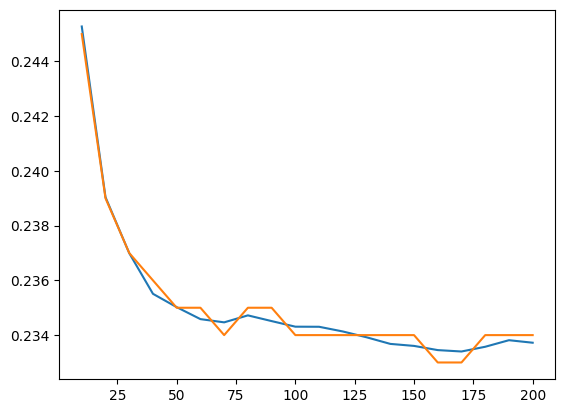

In [17]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

plt.show()

Therefore, after n_estimator = 160, the RMSE stops improving

### Question 4
Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]
For each of these values,
try different values of n_estimators from 10 till 200 (with step 10)
calculate the mean RMSE
Fix the random seed: random_state=1
What's the best max_depth, using the mean RMSE?

In [21]:
# all_rmse = {}

# for d in [10,15,20,25]:
#     print('Depth %s ' %d)
#     rmses = []

#     for i in range(10,201, 10):
#         rf = RandomForestRegressor(n_estimators= i, max_depth = d, random_state = 1,n_jobs=-1)
#         rf.fit(X_train, y_train)
#         y_pred = rf.predict(X_val)
#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#         print('%i -> %.3f' %(i, rmse))
#         rmses.append(rmse)
        
#     all_rmse[d] = rmses
#     print()


scores = []
for d in tqdm([10,15,20,25]):
    rf = RandomForestRegressor(
        n_estimators = 0,
        max_depth = d,
        random_state = 1,
        n_jobs = -1,
        warm_start = True
    )

    for n in tqdm(range(10,201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((d,n,score))

columns = ['max_depth','n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns = columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

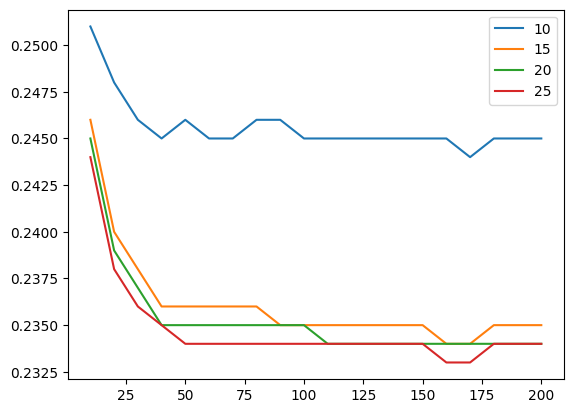

In [27]:
for d in [10,15,20,25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse.round(3), label = d)

plt.legend()
plt.show()

The best max_depth, using the mean RMSE is 25 with a rmse of 0.23

### Question 5
In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parameters:
n_estimators=10,
max_depth=20,
random_state=1,
n_jobs=-1 (optional)
Get the feature importance information from this model
What's the most important feature (among these 4)?

In [28]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1 )
rf.fit(X_train, y_train)

df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending = False)


,feature,importance
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.102007
3,longitude,0.086244
6,ocean_proximity=INLAND,0.073806
1,housing_median_age,0.030317
7,population,0.027136
9,total_rooms,0.021417
8,total_bedrooms,0.015852
0,households,0.015136


Therefore, the most important feature is median_income

### Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

Install XGBoost
Create DMatrix for train and validation
Create a watchlist
Train a model with these parameters for 100 ro

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}unds:

In [29]:
import xgboost as xgb

features = dv.feature_names_
features = [f.replace('<','less') for f in features]
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=less1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [30]:
dtrain= xgb.DMatrix(X_train, label = y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)


In [48]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [49]:
%%capture output_01

watchlist = [(dtrain,'train'), (dval,'val')]
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse', 
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round = 100, 
                  evals = watchlist, 
                  verbose_eval=10)

In [50]:
scores['eta=0.1'] = parse_xgb_output(output_01)

In [51]:
%%capture output_03

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse', 
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round = 100, 
                  evals = watchlist, 
                  verbose_eval=10)

In [52]:
scores['eta=0.3'] = parse_xgb_output(output_03)

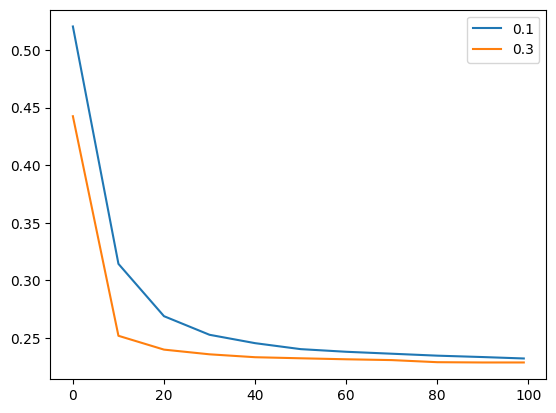

In [53]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()